In [1]:
import keras
# from tensorflow.keras import layers
import scipy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, LeakyReLU

from keras import callbacks
from keras.datasets import mnist
from tensorflow.keras.optimizers import RMSprop, SGD
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from keras.callbacks import ModelCheckpoint, EarlyStopping




%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

tf.Tensor(576.27747, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# <font color=maroon>Model Building (Baseline) - Inception-V3

### Import

In [4]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [5]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 256
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model

In [6]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
pre_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [7]:
pre_model.trainable = False

In [ ]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Baseline')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 20

model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set)

Model: "InceptionV3_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 48,022,826
Trainable params: 26,220,042
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/20


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 1 - Inception-V3

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
# using default image size
IMG_SIZE = 299

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 64
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Change img size to 299
- Changed batch size to 64
- Increased epoch to 50
- Added early stop

In [ ]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
pre_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [ ]:
pre_model.trainable = False

In [ ]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Tuned_1')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'))

Model: "InceptionV3_Tuned_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 88,917,290
Trainable params: 67,114,506
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/50
782/782 [==============================] - 266s 323ms/step - loss: 2.1922 - accuracy: 0.7801 - val_loss: 0.6856 - val_accuracy: 0.7760
Epoch 2/50
7

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 36s 228ms/step - loss: 0.7316 - accuracy: 0.8316
Test loss:  0.7315564155578613
Test accuracy: 0.83160001039505


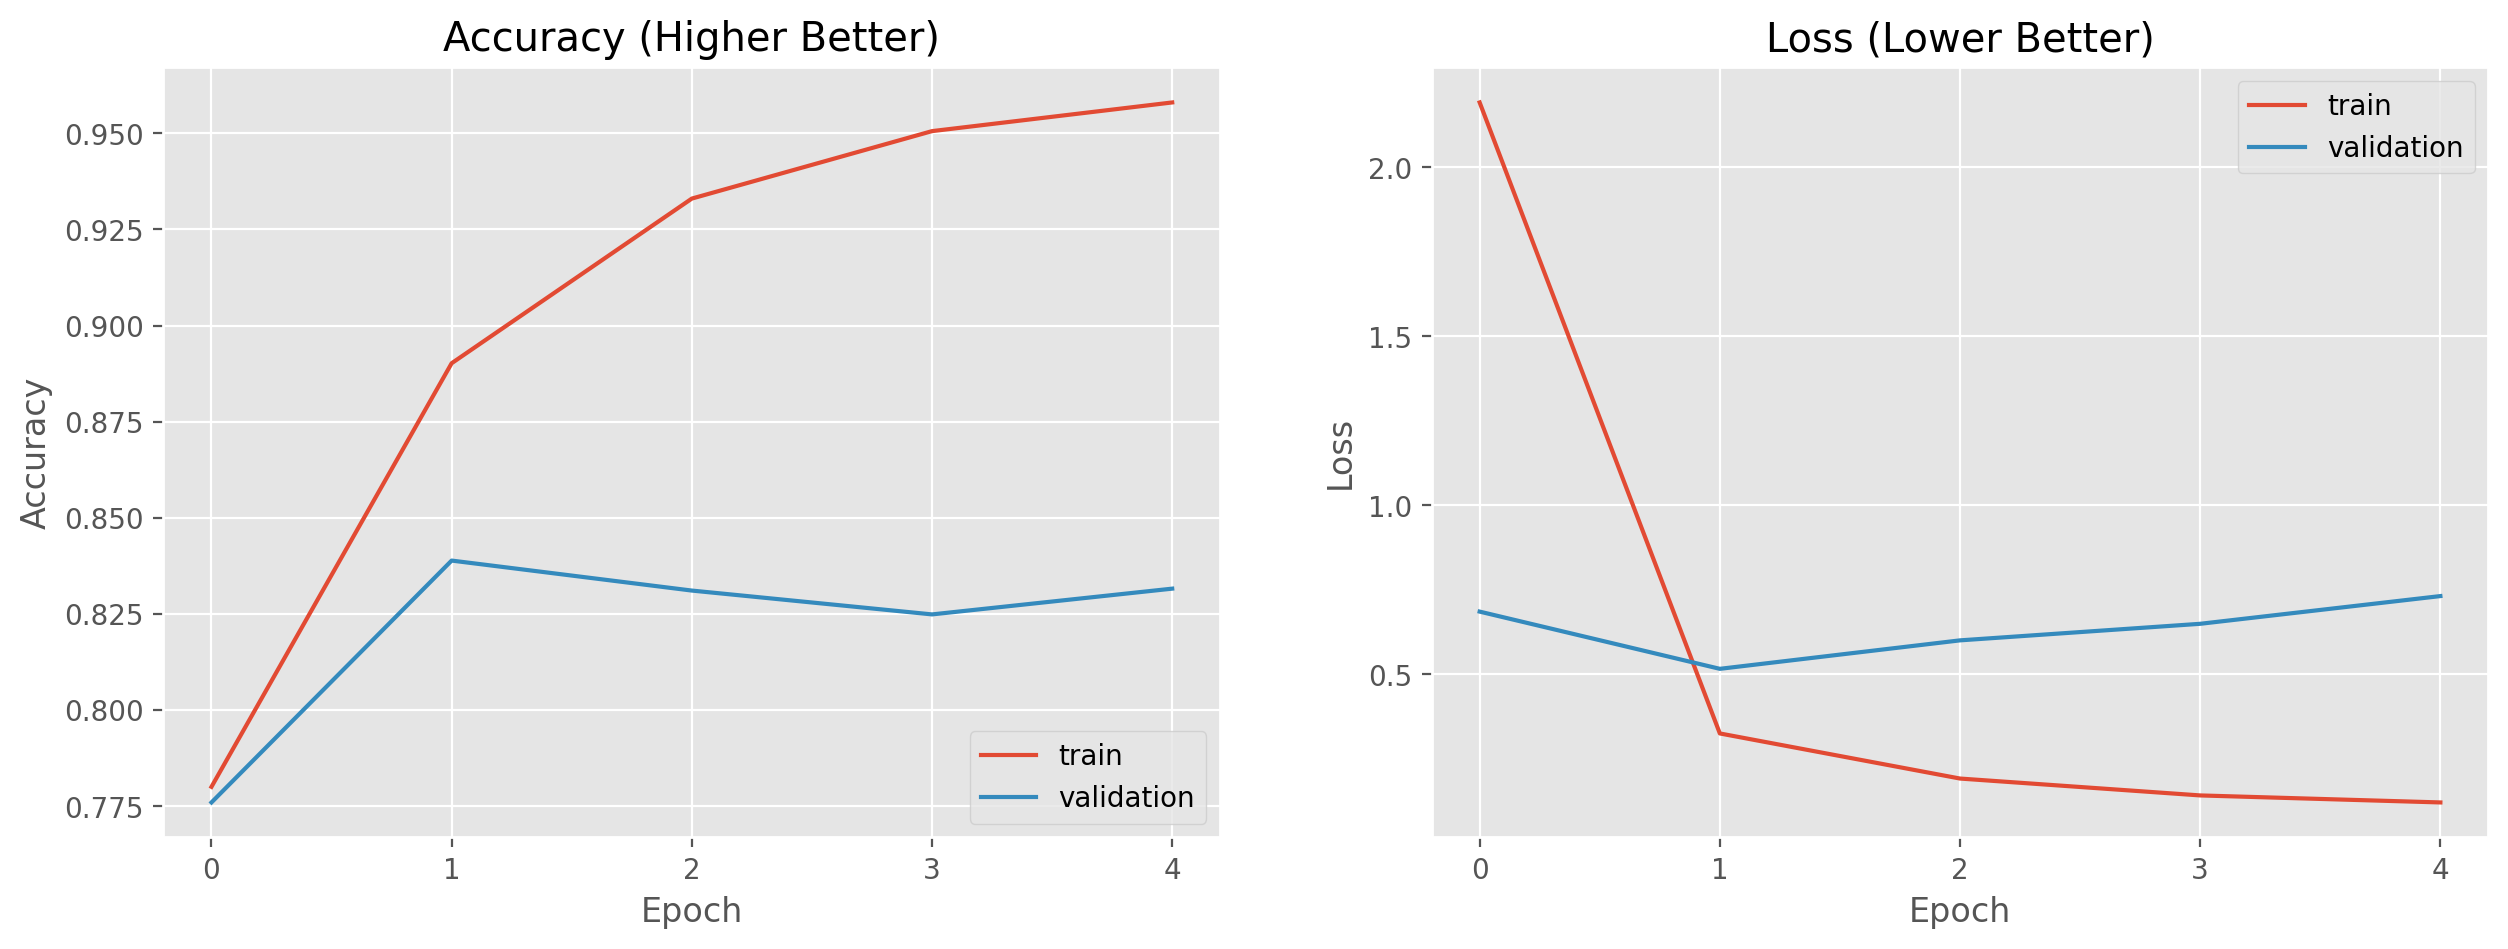

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

157/157 [==============================] - 37s 224ms/step
[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


C:\Users\mctro\AppData\Local\Temp\ipykernel_14716\2615009037.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


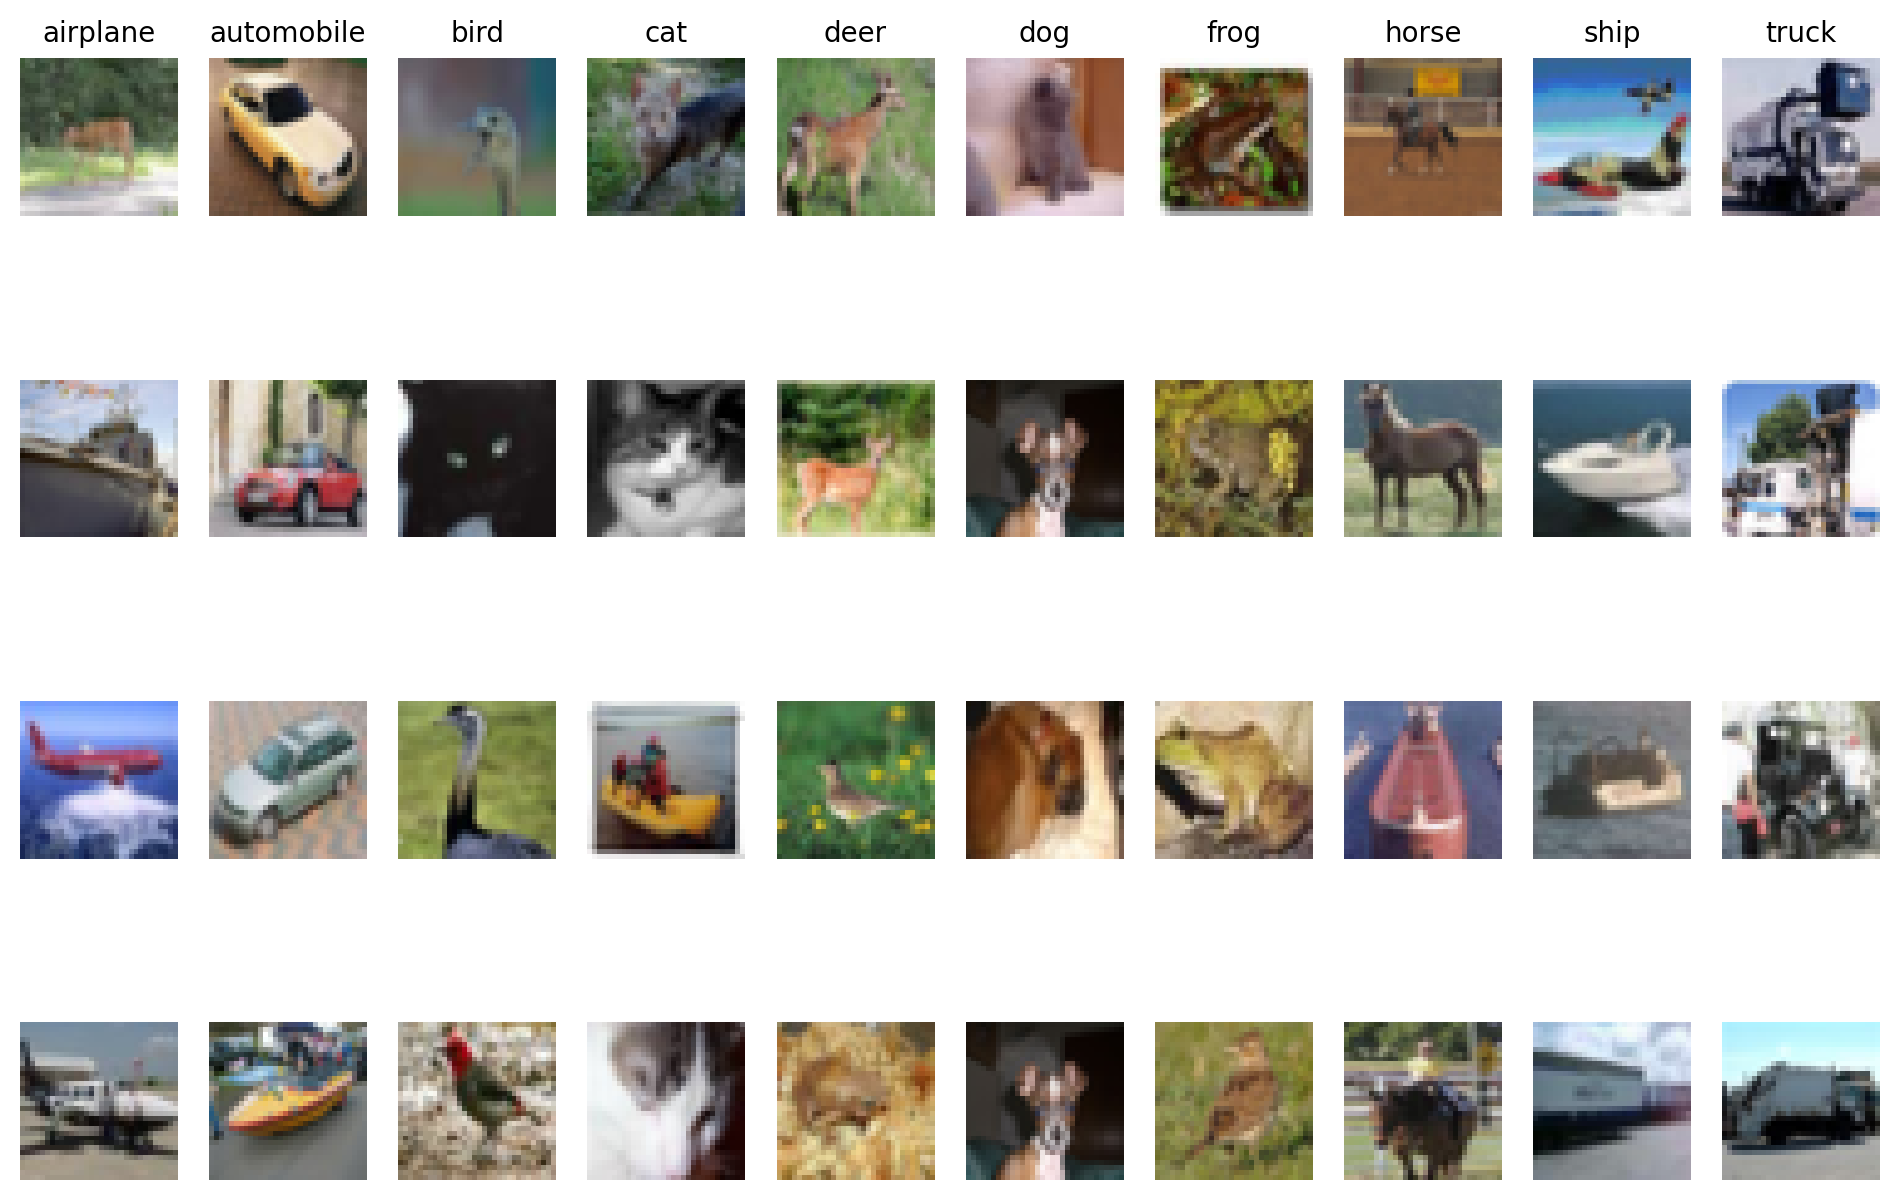

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 2 - Inception-V3

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


### Data Preprocessing

In [ ]:
# using default image size
IMG_SIZE = 299

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Change img size to 299
- Changed batch size to 32
- Increased epoch to 50
- Added early stop
- Set trainable = True

In [ ]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# pre_model.summary()

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
pre_model.trainable = True

In [ ]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Tuned_2')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 20

model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'))

Model: "InceptionV3_Tuned_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 88,917,290
Trainable params: 88,882,858
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/20
1563/1563 [==============================] - 769s 456ms/step - loss: 1.6952 - accuracy: 0.4539 - val_loss: 1.0988 - val_accuracy: 0.6194
Epoch 2/20
156

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 37s 116ms/step - loss: 0.5111 - accuracy: 0.8511
Test loss:  0.5110715627670288
Test accuracy: 0.8511000275611877


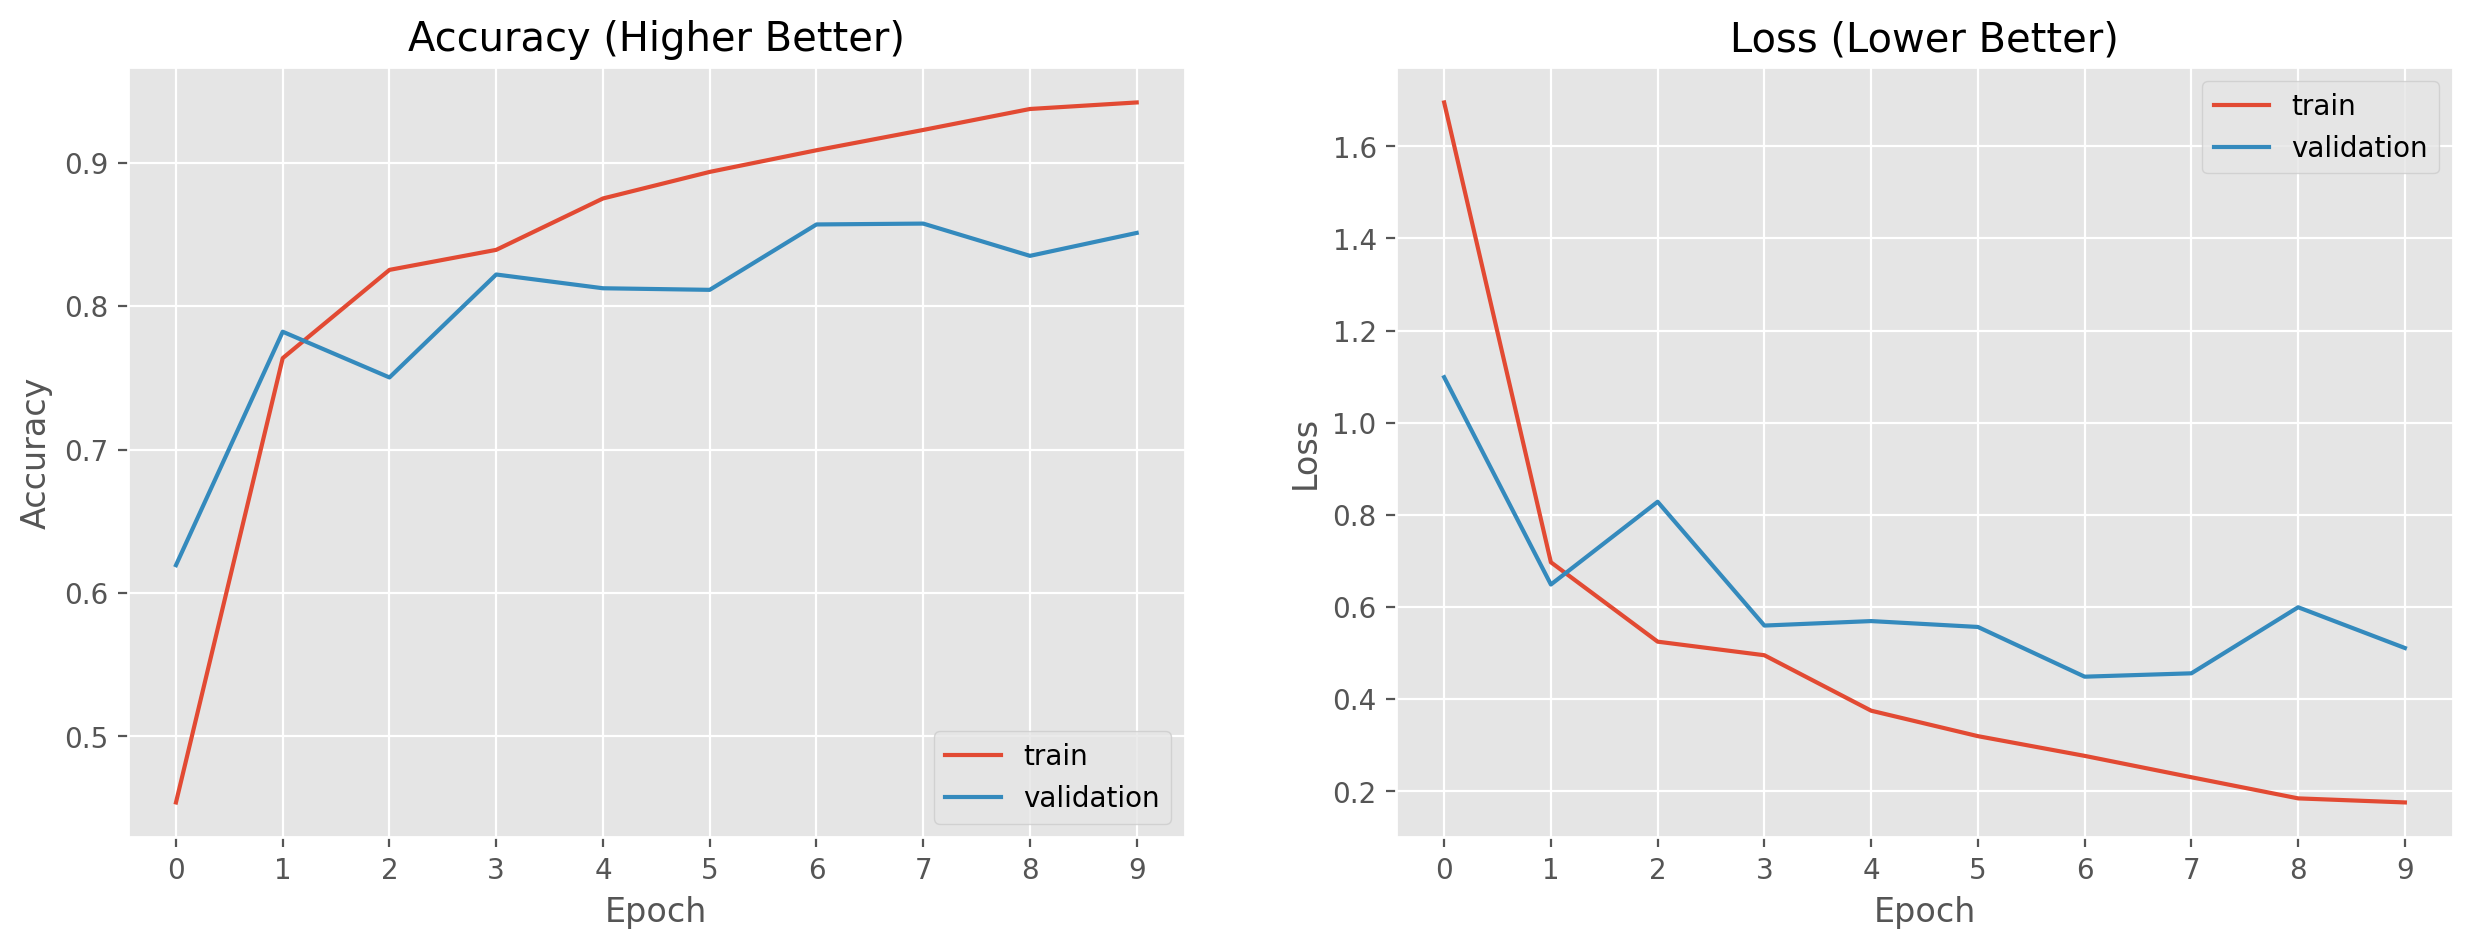

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 37s 114ms/step
[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


<ipython-input-13-8830efd3c24d>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


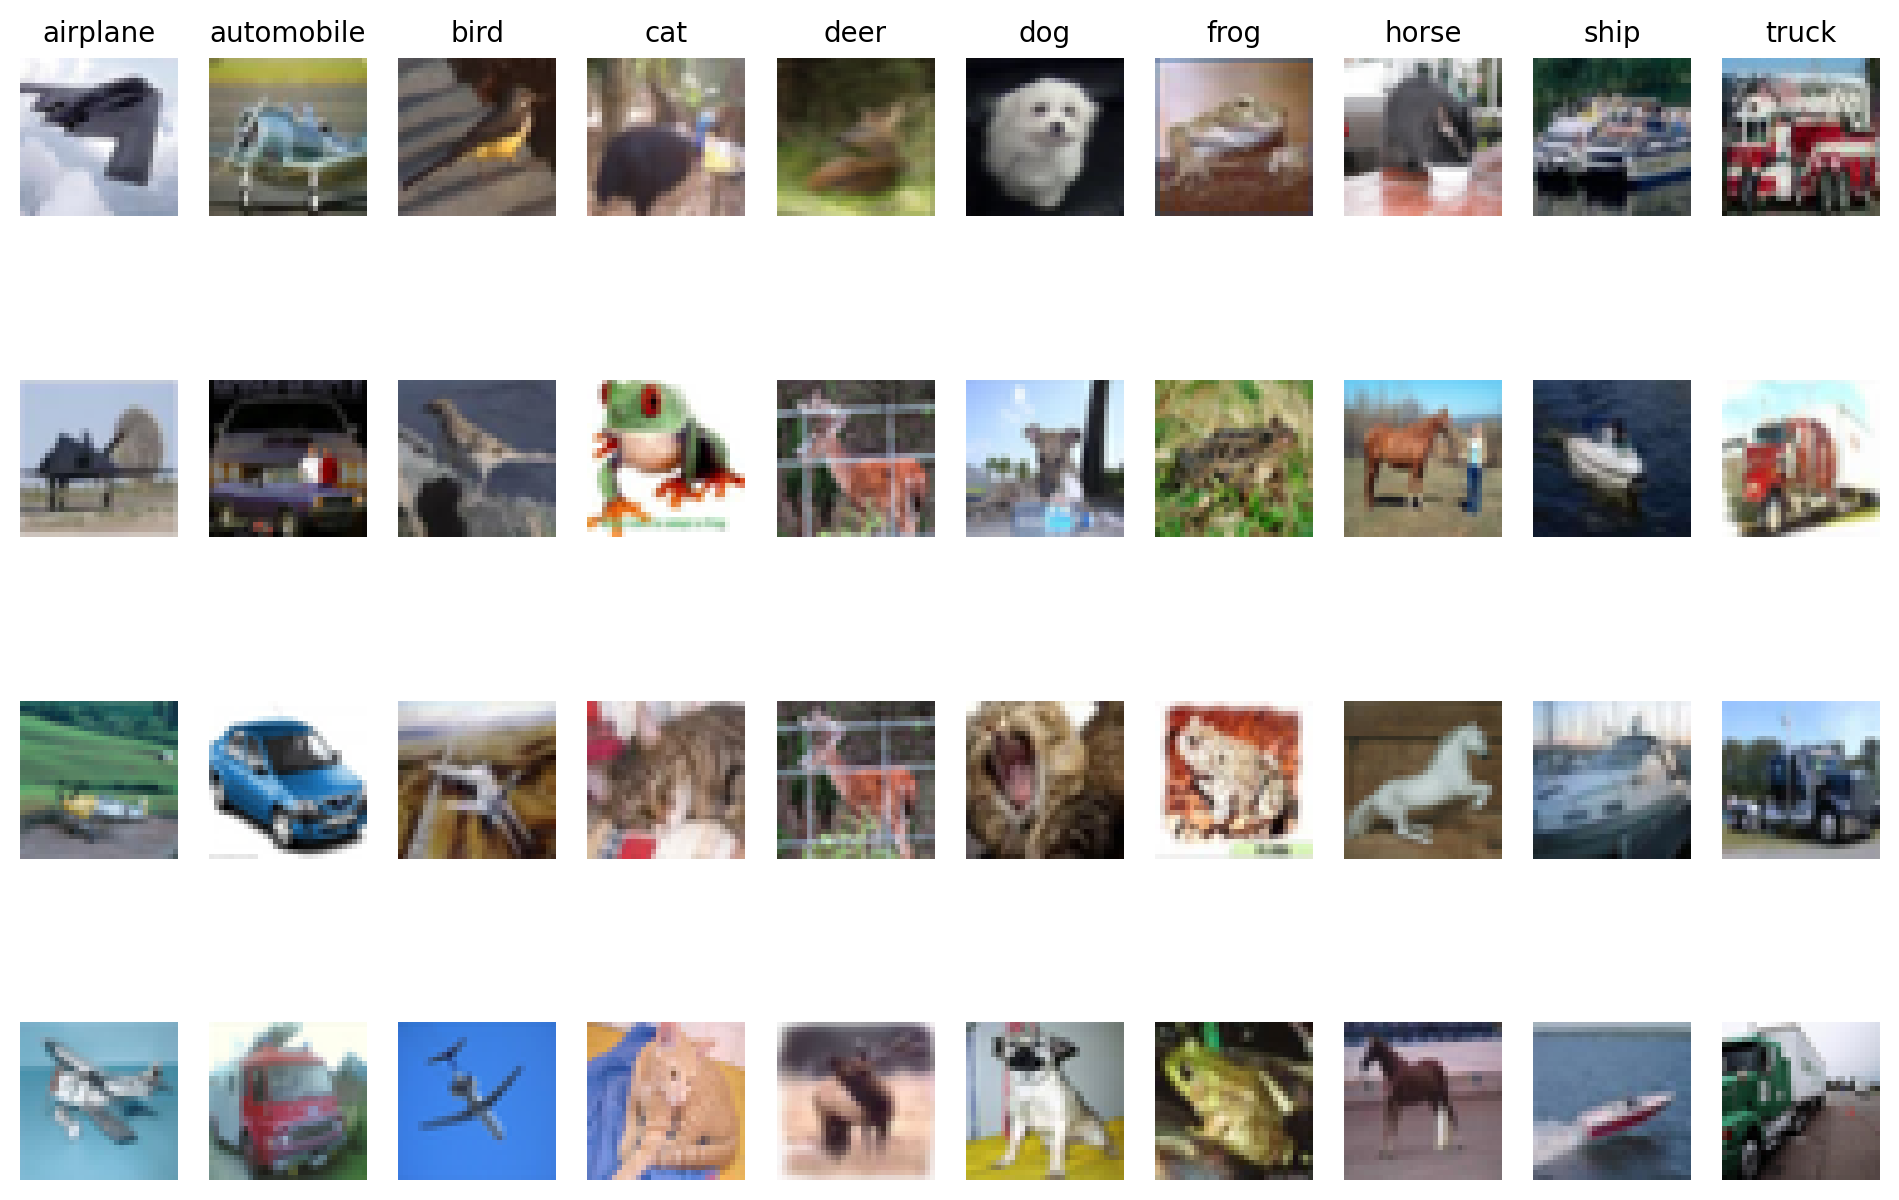

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 3 - Inception-V3

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# user keras preprocessing
x_train = keras.applications.inception_v3.preprocess_input(x_train)
x_test = keras.applications.inception_v3.preprocess_input(x_test)

# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Change img size to 224
- Changed batch size to 32
- Increased epoch to 50
- Added early stop
- Set trainable = True
- Removed normalisation
- use Keras Preprcoessing

In [ ]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# pre_model.summary()

In [ ]:
pre_model.trainable = True

In [ ]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Tuned_3')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop])

Model: "InceptionV3_Tuned_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 48,022,826
Trainable params: 47,988,394
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/50
1563/1563 [==============================] - 456s 255ms/step - loss: 1.3176 - accuracy: 0.5445 - val_loss: 0.8798 - val_accuracy: 0.7177
Epoch 2/50
156

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 22s 70ms/step - loss: 0.4139 - accuracy: 0.8976
Test loss:  0.41385436058044434
Test accuracy: 0.897599995136261


In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 22s 65ms/step
[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


<ipython-input-13-8830efd3c24d>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


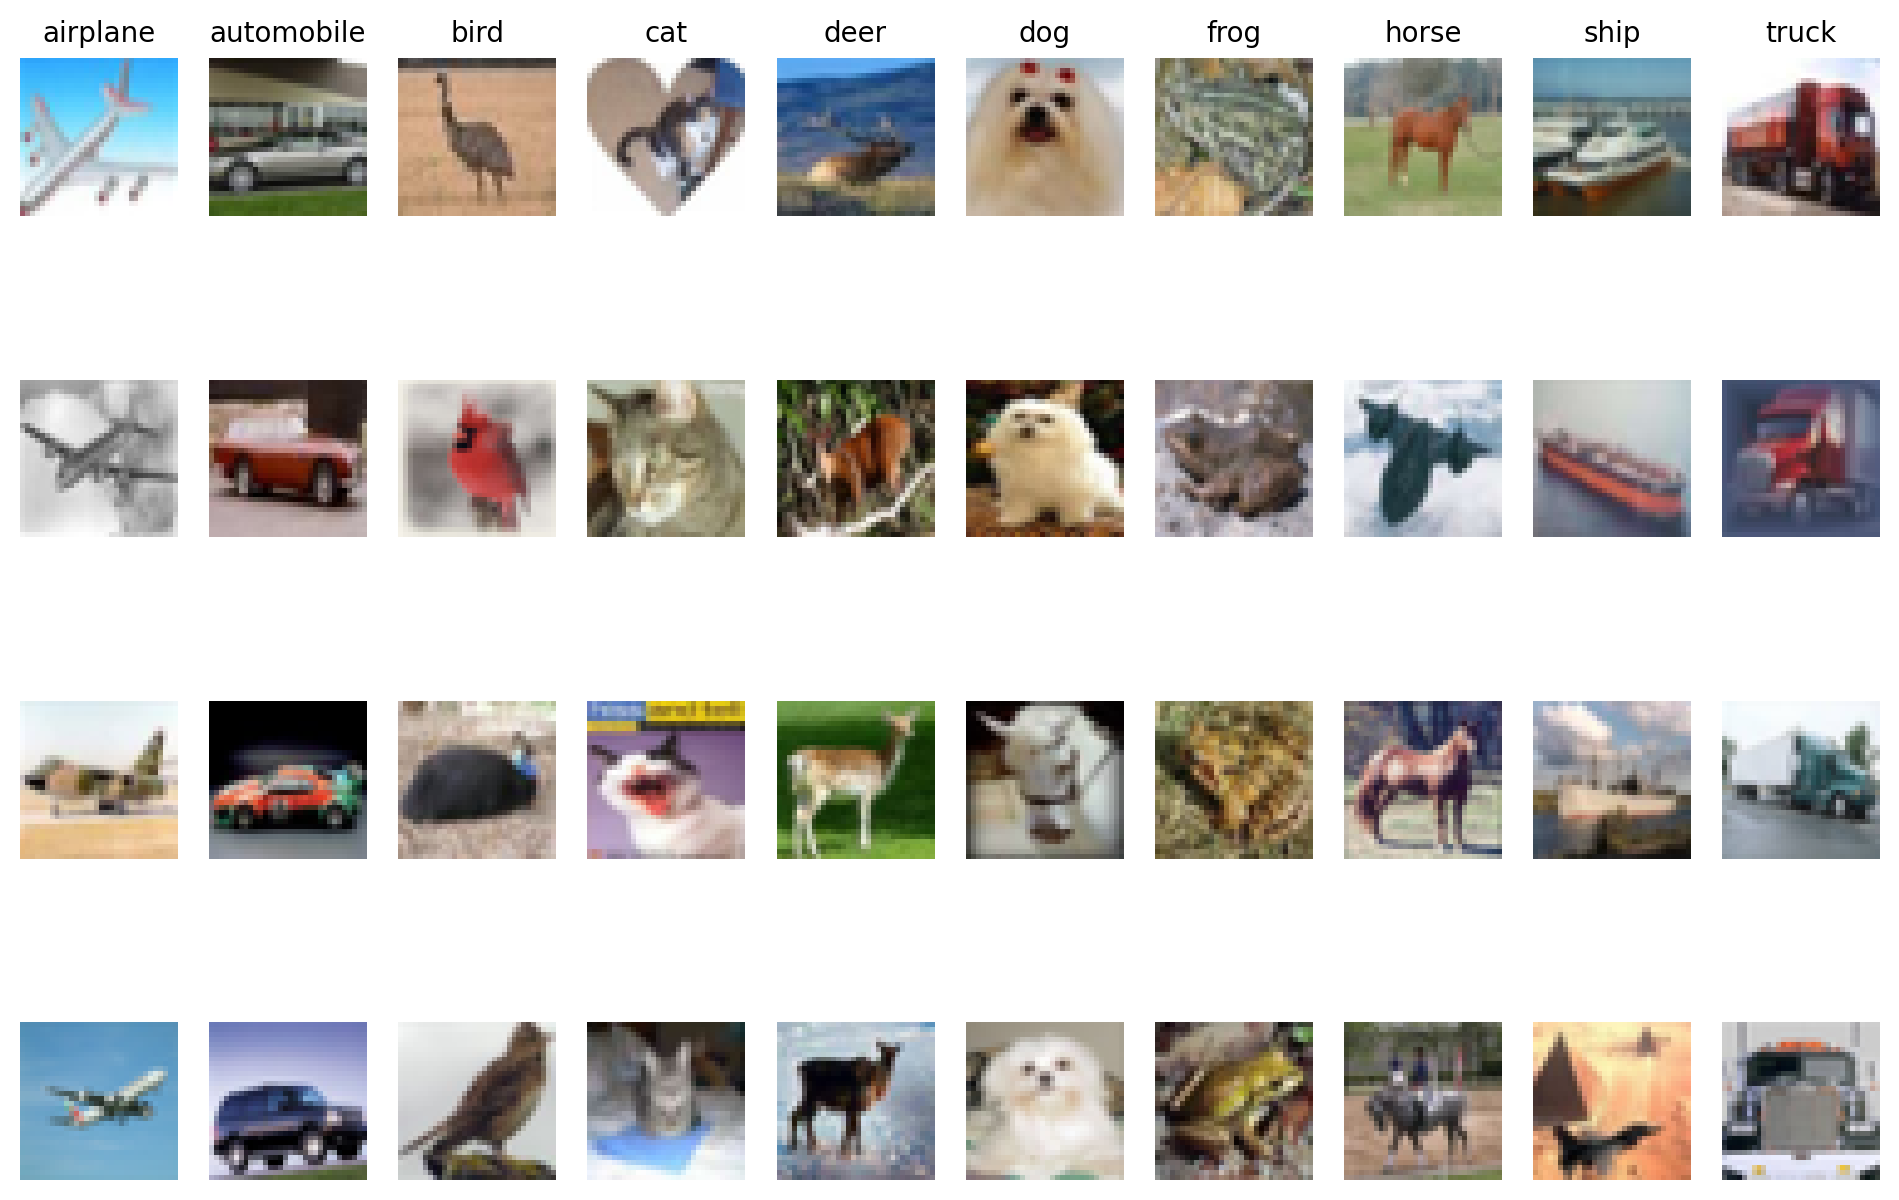

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 4 - Inception-V3

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


### Data Preprocessing

In [ ]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# user keras preprocessing
x_train = keras.applications.inception_v3.preprocess_input(x_train)
x_test = keras.applications.inception_v3.preprocess_input(x_test)

# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 128
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Change img size to 224
- Changed batch size to 128
- Increased epoch to 50
- Added early stop
- Set trainable = True
- Removed normalisation
- use Keras Preprcoessing
- Added layers into fully conencted layers

In [ ]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# pre_model.summary()

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in pre_model.layers:
  layer.trainable = True

In [ ]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Tuned_4')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop])

Model: "InceptionV3_Tuned_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 48,414,250
Trainable params: 48,3

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

79/79 [==============================] - 6s 78ms/step - loss: 0.5130 - accuracy: 0.8957
Test loss:  0.5129584670066833
Test accuracy: 0.8956999778747559


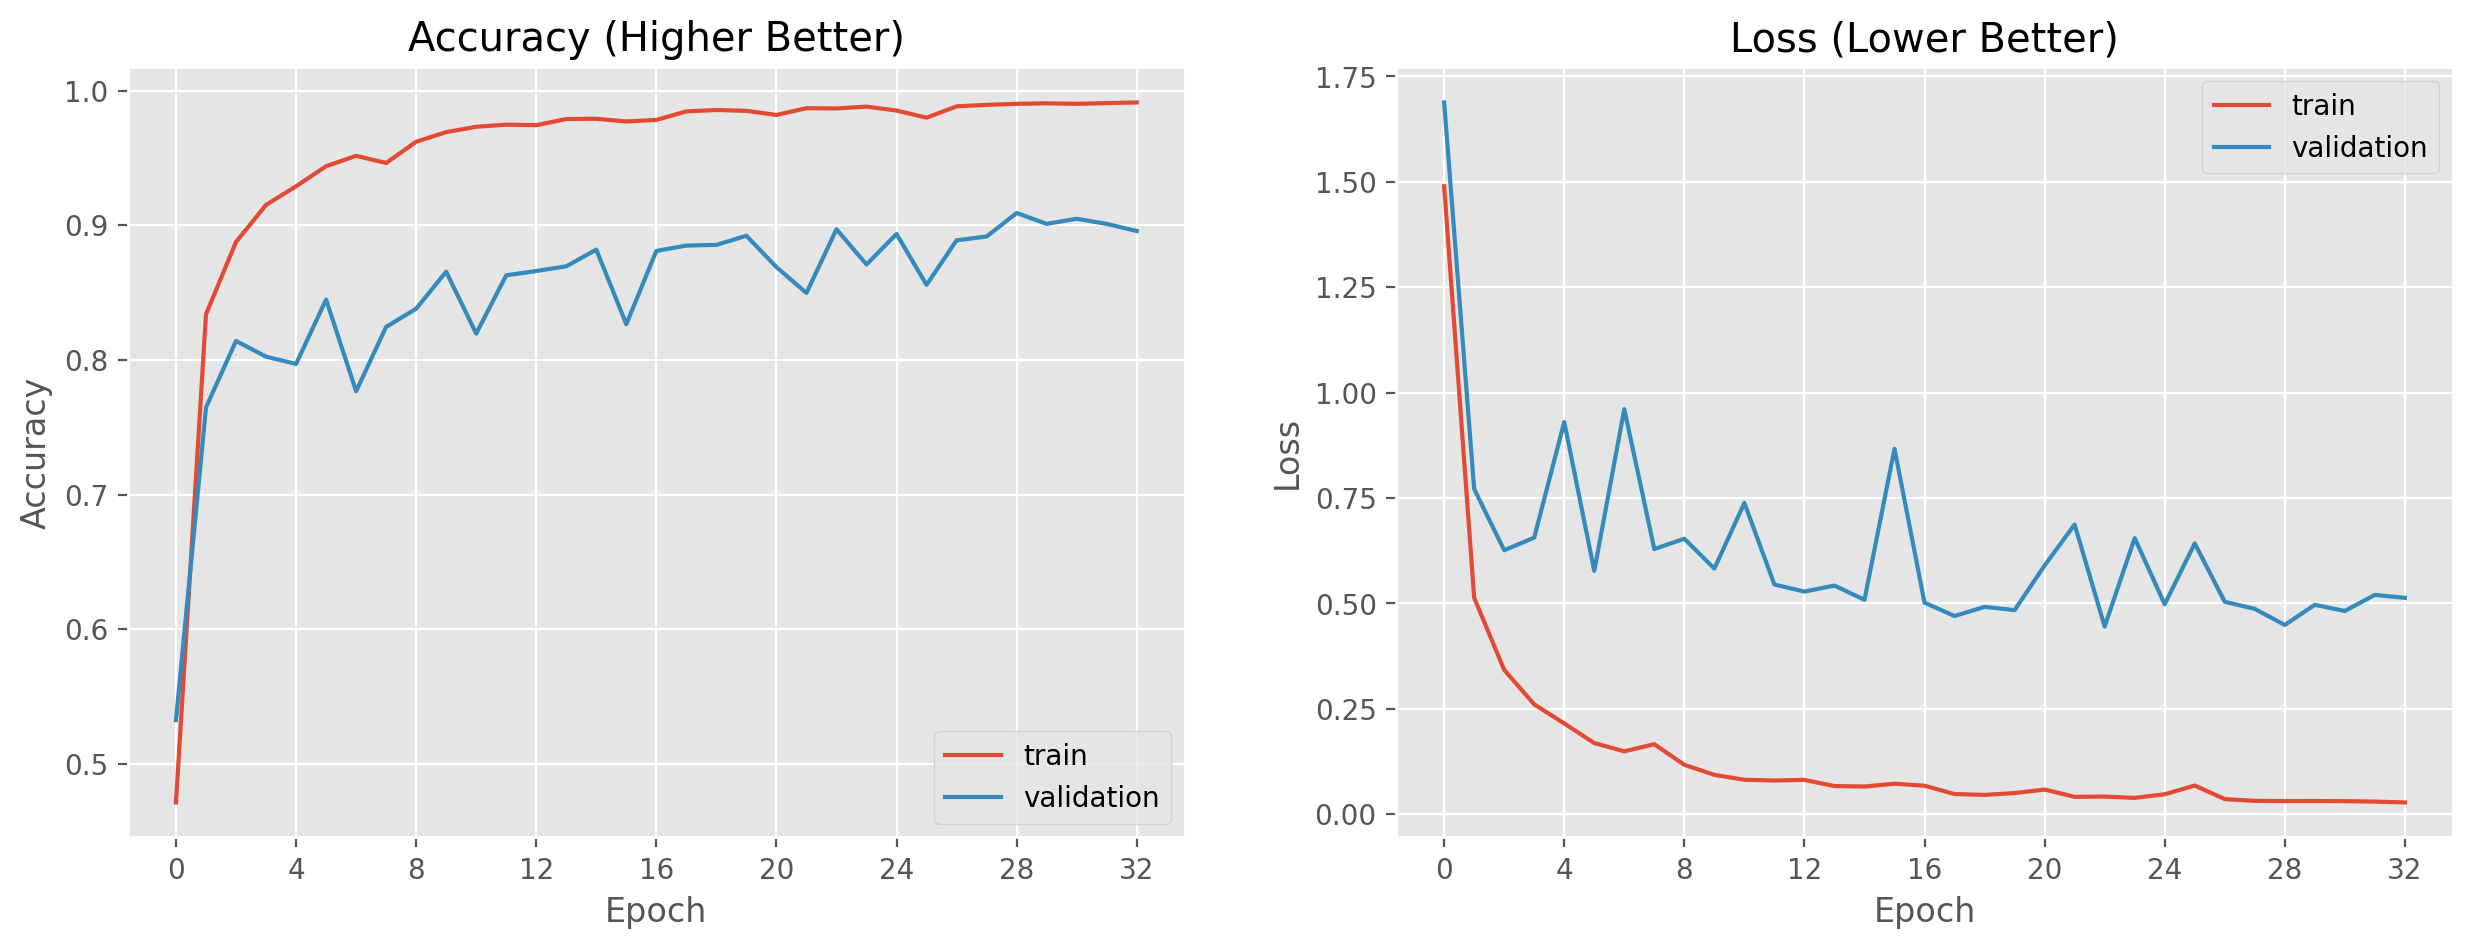

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

79/79 [==============================] - 7s 72ms/step
[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


<ipython-input-13-8830efd3c24d>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


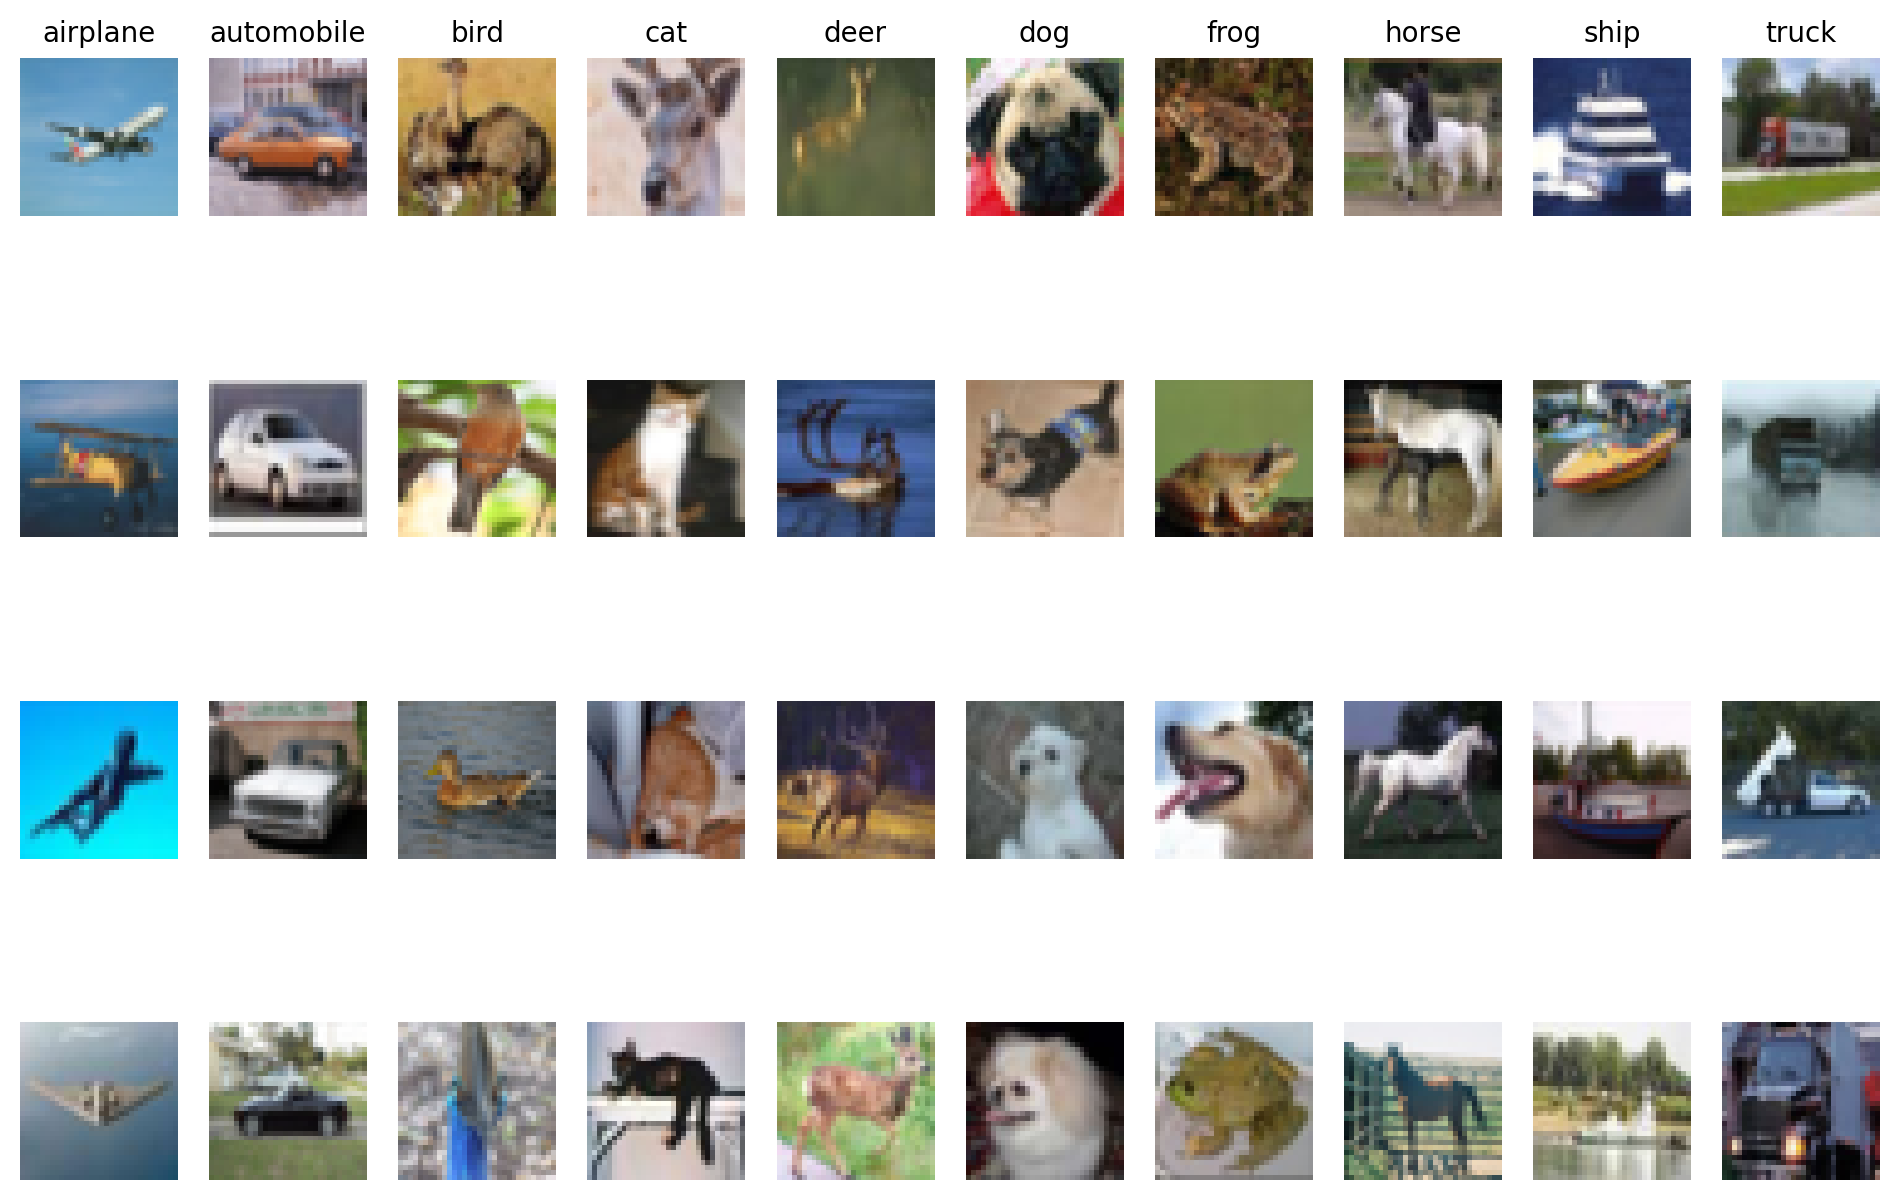

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 5 - Inception-V3

### Import

In [2]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [3]:
# using default image size
IMG_SIZE = 299

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# user keras preprocessing
x_train = keras.applications.inception_v3.preprocess_input(x_train)
x_test = keras.applications.inception_v3.preprocess_input(x_test)

# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# define batch size
batch_size = 32

# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Change img size to 299
- Changed batch size to 128
- Increased epoch to 50
- Added early stop
- Set trainable = True
- Removed normalisation
- use Keras Preprcoessing
- Decreased Batch size to 32
- Added layers into fully conencted layers
- Added dropouts to prevent overfitting
- Added learning Rate scheduler 

In [4]:
pre_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# pre_model.summary()

In [5]:
for layer in pre_model.layers:
    layer.trainable = True

In [6]:
# build InceptionV3 model
model = Sequential(name='InceptionV3_Tuned_5')
model.add(pre_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

callback = []
def decay(epoch):
    return 0.001 / (1 + 1 * 30)

callback += [keras.callbacks.LearningRateScheduler(decay)]

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop, callback])

Model: "InceptionV3_Tuned_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)       

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 13s 43ms/step - loss: 0.1889 - accuracy: 0.9634
Test loss:  0.18887032568454742
Test accuracy: 0.9634000062942505


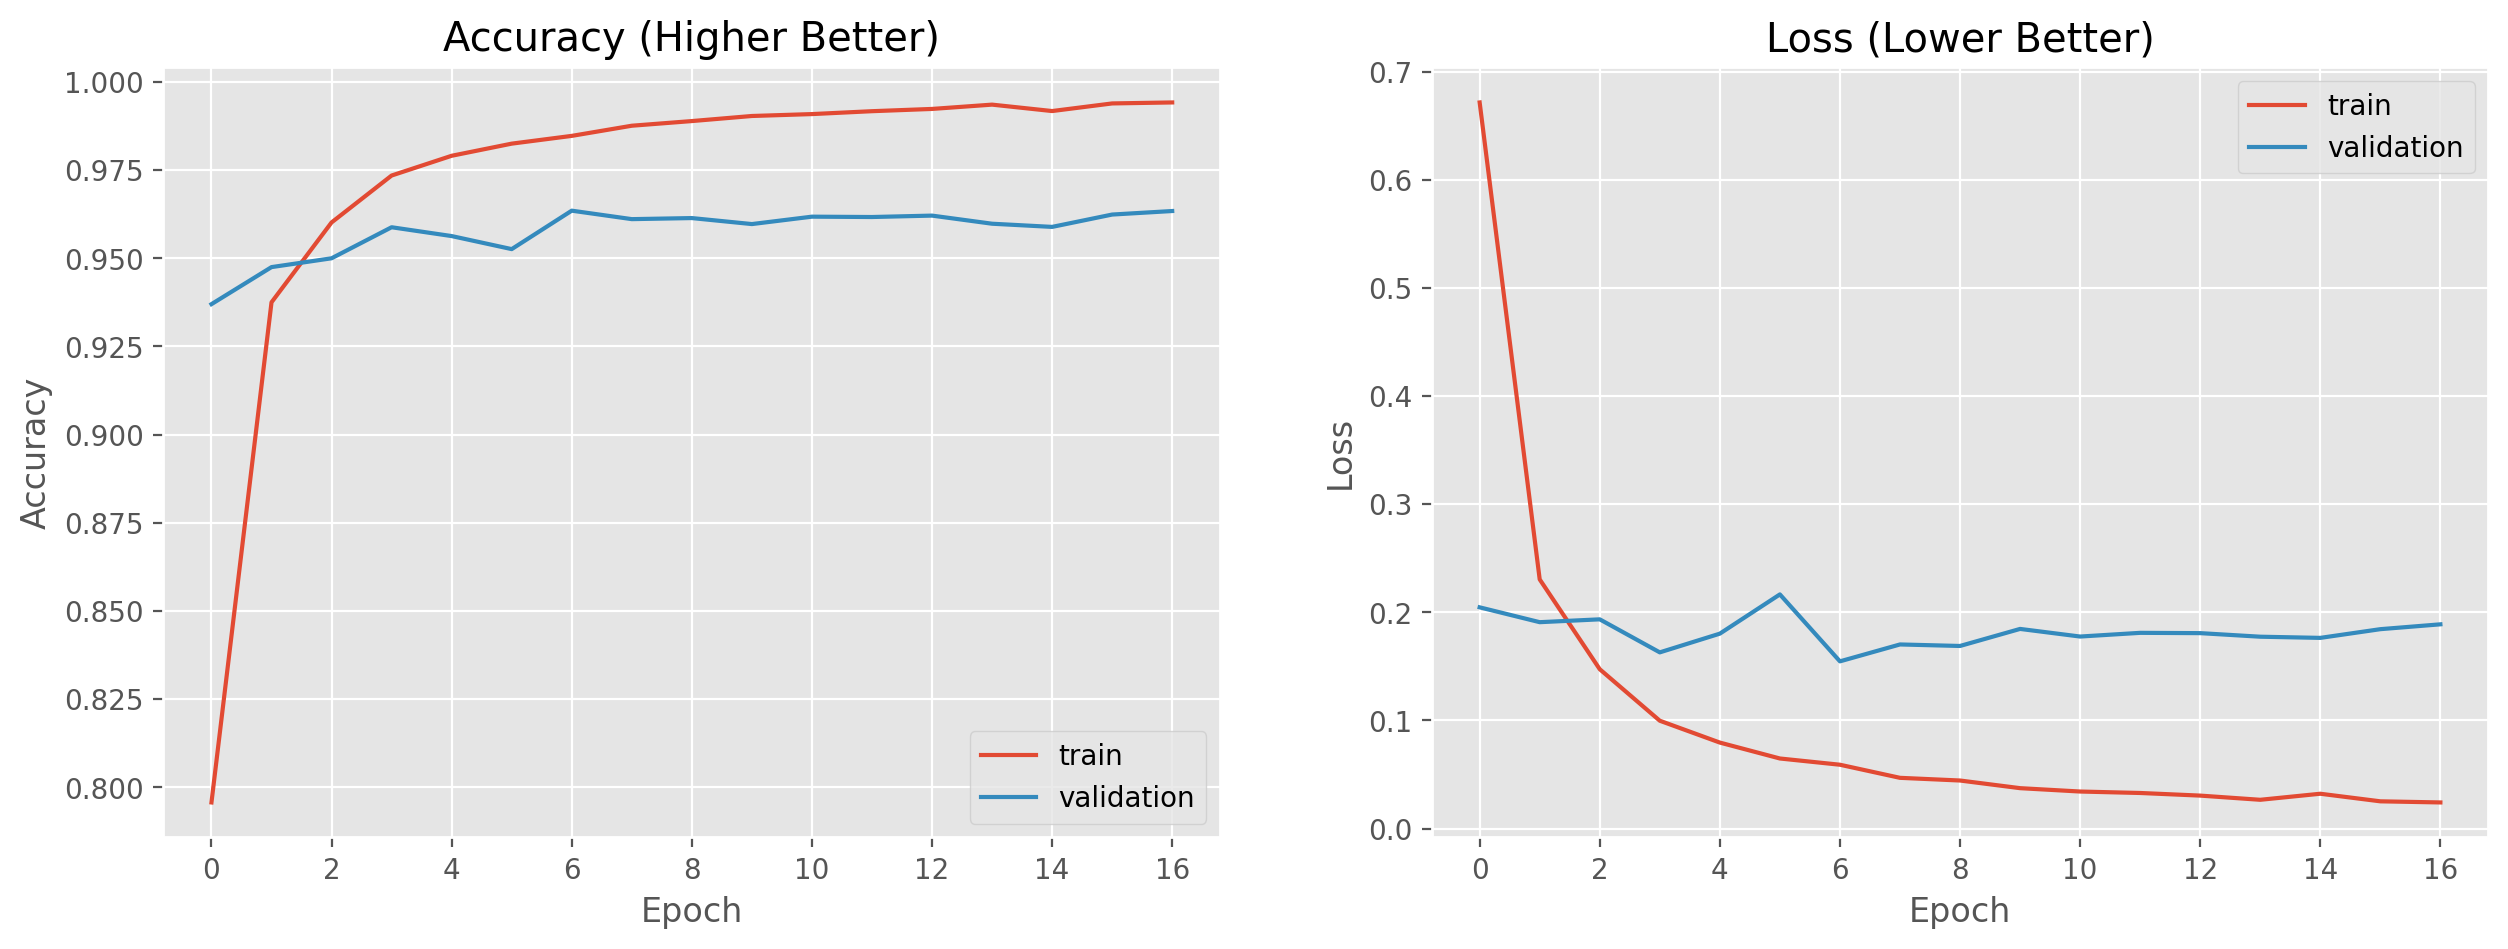

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [9]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 14s 40ms/step
[3 8 1 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [12]:
print(err_x.shape)

(1000, 32, 32, 3)


In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)
